In [1]:
import shutil
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.models import save_model
import cv2

In [2]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [3]:
train.diagnosis.value_counts() 

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [4]:
train_val_split = 0.2

In [5]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/traindata/train', target_size = (150,150), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/traindata/train', target_size = (150,150), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
# Calculate class frequencies
class_freq = {}
for i in range(5):
    class_freq[i] = sum(train_generator.labels == i)

# Calculate class weights
total = sum(class_freq.values())
class_weights = {i: total/class_freq[i] for i in range(5)}

In [7]:
import matplotlib.pyplot as plt

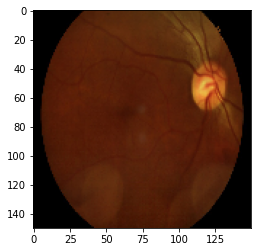

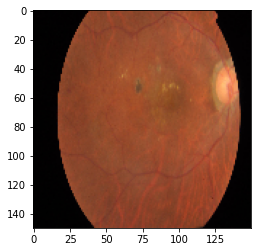

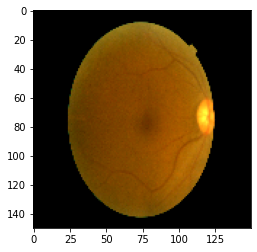

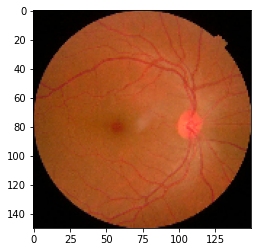

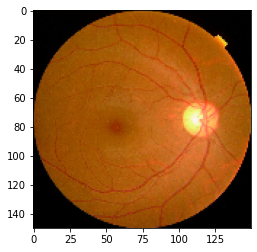

In [8]:
for i in range(0,5):
  img,label = train_generator.next()
  plt.imshow(img[1])
  plt.show()

In [9]:
from tensorflow.keras.applications import VGG16

In [11]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print(conv_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

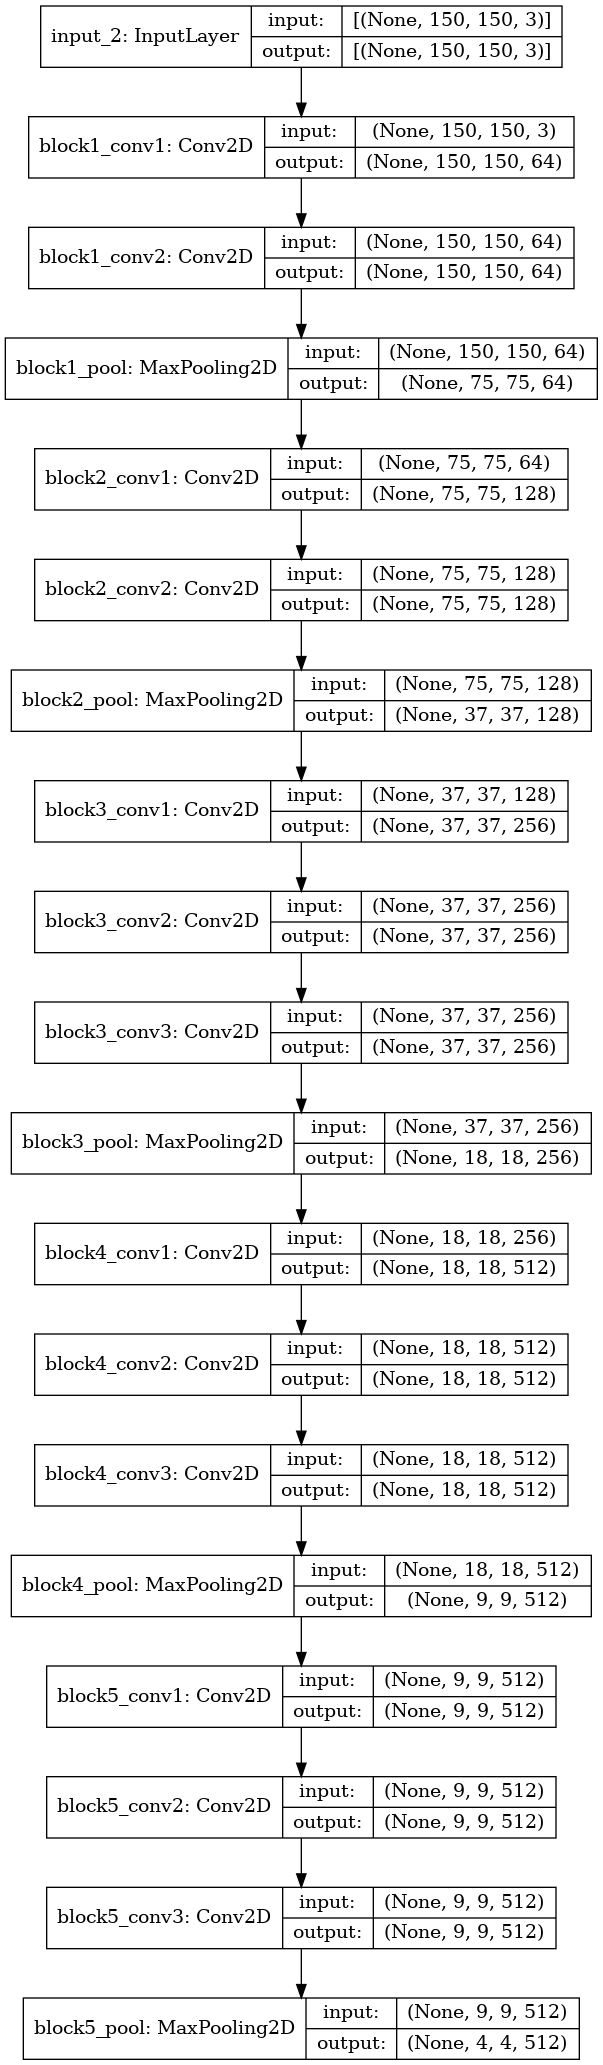

In [12]:
tf.keras.utils.plot_model(conv_base, to_file='VGG16.png', show_shapes=True,show_layer_names=True, rankdir='TB', expand_nested=True)

In [13]:
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.5)) #dropout - to reduce over fitting - deactivate 50% of neurons in each epoch randomly
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=2e-5) , metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
import keras

In [17]:
check_pt = keras.callbacks.ModelCheckpoint("Early_Stop.h5", save_best_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [21]:
len(validation_generator)

37

In [22]:
validation_freq=1

In [18]:
model_history = model.fit(train_generator,
                                    steps_per_epoch = len(train_generator),
                                    epochs = 20,
                                    validation_data = validation_generator,class_weight=class_weights,
                                    validation_steps = len(validation_generator),
                                    callbacks=[check_pt, early_stop])

2023-01-19 04:25:09.521023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-19 04:25:14.891338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 492s 3s/step - loss: 7.2059 - accuracy: 0.5046 - val_loss: 1.0020 - val_accuracy: 0.5280
Epoch 2/10
147/147 [==============================] - 425s 3s/step - loss: 6.3281 - accuracy: 0.5950 - val_loss: 0.9431 - val_accuracy: 0.5718
Epoch 3/10
147/147 [==============================] - 428s 3s/step - loss: 5.8338 - accuracy: 0.6387 - val_loss: 1.2080 - val_accuracy: 0.4733
Epoch 4/10
147/147 [==============================] - 384s 3s/step - loss: 5.5261 - accuracy: 0.6554 - val_loss: 1.0267 - val_accuracy: 0.5486
Epoch 5/10
147/147 [==============================] - 381s 3s/step - loss: 5.2521 - accuracy: 0.6755 - val_loss: 0.7252 - val_accuracy: 0.7073
Epoch 6/10
147/147 [==============================] - 379s 3s/step - loss: 5.1826 - accuracy: 0.6783 - val_loss: 0.7406 - val_accuracy: 0.6949
Epoch 7/10
147/147 [==============================] - 379s 3s/step - loss: 5.0024 - accuracy: 0.7049 - val_loss: 0.8041 - val_accuracy: 0.6484
Epoch 8/10

In [40]:
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Compute accuracy
#acc = accuracy_score(y_true, y_pred)
#print("Accuracy:", acc)

# Compute MSE
mse = mean_squared_error(y_true, y_pred)
print("MSE:", mse)

#Compute MAE
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

MSE: 2.045143638850889
MAE: 1.1723666210670314


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Compute precision
prec = precision_score(y_true, y_pred,average = 'micro')
print("Precision:", prec)

# Compute recall
rec = recall_score(y_true, y_pred,average = 'micro')
print("Recall:", rec)

# Compute f1 score
f1 = f1_score(y_true, y_pred,average = 'micro')
print("F1 Score:", f1)

Precision: 0.14500683994528044
Recall: 0.14500683994528044
F1 Score: 0.14500683994528044


In [ ]:
pd.DataFrame(model_history.history).plot()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(model_history.history['accuracy'])
#plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_generator', 'validation_generator'], loc='lower right')
plt.show()

In [ ]:
plt.plot(model_history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()